In [155]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime
import gzip
import scipy.io
import matplotlib.gridspec as gridspec


from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# %matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 12
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


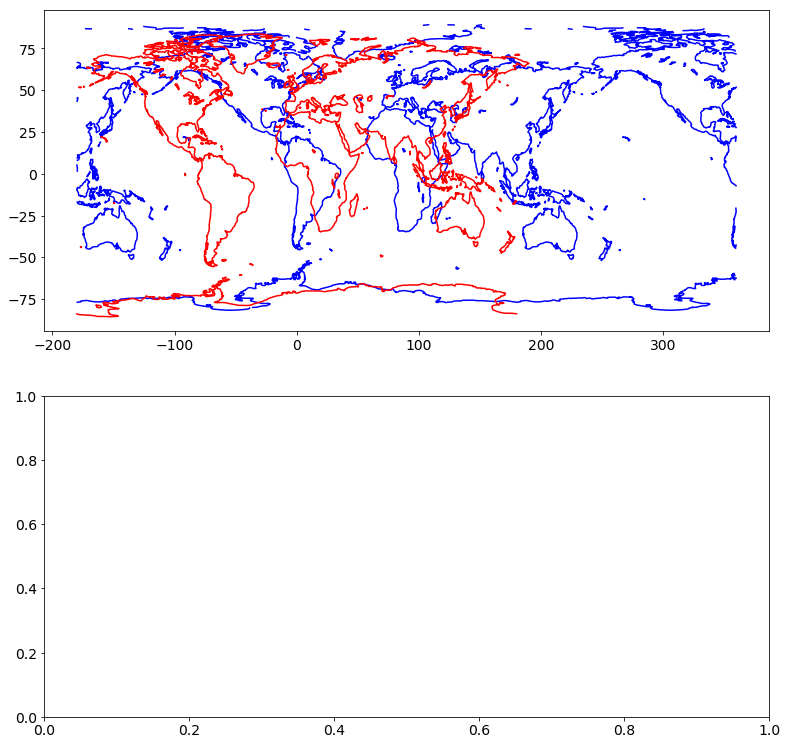

In [156]:
# Load coastlines:
import xflib
itime = datetime.datetime(2010,1,1,0,0,0)

# Convert the Matlab coastline datafile to geomagnetic coordinates:

xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
coastlines = scipy.io.loadmat('coastlines.mat')
coast_lat_mag = np.zeros(len(coastlines['lat']))
coast_lon_mag = np.zeros(len(coastlines['long']))

for ind, (lat, lon) in enumerate(zip(coastlines['lat'], coastlines['long'])):
    if np.isnan(lat) or np.isnan(lon):
        coast_lat_mag[ind] = np.nan
        coast_lon_mag[ind] = np.nan
    else:
        tmpcoords = [1, lat[0], lon[0]]
        tmp_mag = xf.rllgeo2rllmag(tmpcoords, itime)
        coast_lat_mag[ind] = tmp_mag[1]
        coast_lon_mag[ind] = tmp_mag[2]

# Loop around for -180 + 180 ranges
coast_lat_mag = np.concatenate([coast_lat_mag, coast_lat_mag[coast_lon_mag > 180]])
coast_lon_mag = np.concatenate([coast_lon_mag, (coast_lon_mag[coast_lon_mag > 180] - 360)])

# Toss in some NaNs to break up the continents
for ind in range(len(coast_lat_mag) -1):
    if ((np.abs(coast_lat_mag[ind+1] - coast_lat_mag[ind]) > 5) or
       (np.abs(coast_lon_mag[ind+1] - coast_lon_mag[ind]) > 5)):
        coast_lat_mag[ind] = np.nan
        coast_lon_mag[ind] = np.nan

    
fig, ax = plt.subplots(2,1)
ax[0].plot(coast_lon_mag, coast_lat_mag, 'b')
ax[0].plot(coastlines['long'],coastlines['lat'],'r')

In [157]:
# Load input energies (precalculated), convert to densities
inlats = [50, 35, 15]
mlts   = [0, 12]
rootdir ='/shared/users/asousa/WIPP/WIPP_stencils/'
power_dir    = os.path.join(rootdir,'outputs','input_energies_0.25deg')

R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.

I0 = 10000.
all_data = []
for inlat in inlats:
    for mlt in [0, 12]:
        fn = os.path.join(power_dir,'input_energy_%d_%d.pklz'%(inlat, mlt))
        print os.path.exists(fn)
        with gzip.open(fn,'rb') as file:
            data = pickle.load(file)
        
        
        # Get areas of each cell (for energy density)
        
        areas = np.zeros([len(data['clats']), len(data['clons'])])
        
        
        dlat = data['clats'][1] - data['clats'][0]
        dlon = data['clons'][1] - data['clons'][0] 
        
        # Get areas of each cell, in km:
        cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos(data['clats']*D2R))
        
        # Sum over frequencies:
        data['pwr'] = np.sum(data['pwr'], axis=0)
        data['pwr']*= pow(I0,2)  # scale by peak current
        data['pwr']/= cell_areas[:, np.newaxis] # Divide by area to get density
        data['pwr'] = np.hstack([np.fliplr(data['pwr'][:,:-1]), data['pwr']]) # Flip for both sides of flash
        
        x = data['clons']
        data['clons'] = np.hstack([x[:-1] - x[-1] + x[0], x])
        print np.shape(data['clons'])
        print np.shape(data['clats'])
        print np.shape(data['pwr'])
        all_data.append(data)


True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)


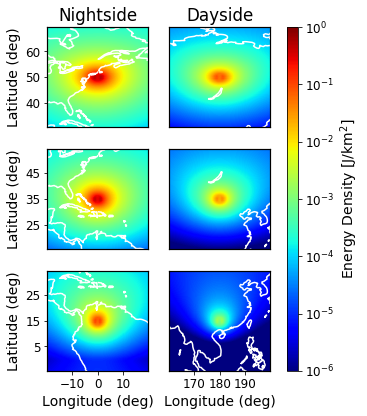

In [158]:
# Do a nice plot
# --------------- Latex Plot Beautification --------------------------
fig_width = 4.2 
fig_height = 5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

fig = plt.figure()
gs = gridspec.GridSpec(len(inlats),3, width_ratios=[1,1,0.1])
print gs
ax = []

cmap = plt.get_cmap('jet')
clims = [-6,0]
for i in range(len(inlats)):
    ax.append(plt.subplot(gs[i,0]))
    ax.append(plt.subplot(gs[i,1]))
cbax = plt.subplot(gs[:,-1])




for i in range(2*len(inlats)):
    [j.set_linewidth(1.2) for j in ax[i].spines.itervalues()]  # Thick borders

    lats = all_data[i]['clats']
    lons = all_data[i]['clons']
    
    # Interpolate onto a smoother axis for plotting
    newlats = np.linspace(lats[0], lats[-1], 200)
    newlons = np.linspace(lons[0], lons[-1], 200)
    interp = interpolate.RegularGridInterpolator([lats, lons], np.log10(all_data[i]['pwr']))
    px, py = np.meshgrid(newlons, newlats)
    pts = zip(py.ravel(), px.ravel())
    D_interp = (interp(pts)).reshape(len(newlons), len(newlats))

    p = ax[i].pcolorfast(newlons, newlats, D_interp, cmap=cmap, vmin=clims[0], vmax=clims[1])
#     p = ax[i].pcolorfast(lons, lats, np.log10(all_data[i]['pwr']), cmap = cmap, vmin=clims[0], vmax=clims[1])
    ax[i].plot(coast_lon_mag, coast_lat_mag, 'w')

    ax[i].set_xlim([lons[0], lons[-1]])
    ax[i].set_ylim([lats[0], lats[-1]])
    ax[i].set_aspect('equal')
    

cb = plt.colorbar(p, cax=cbax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Energy Density [J/km$^2$]')

ax = np.reshape(ax, [len(inlats),2])

for i in range(len(inlats)):
    ax[i,1].set_yticks([])
    ax[i,0].set_ylabel('Latitude (deg)')
    ax[i,0].set_yticks(np.arange(-1,2,1)*10 + inlats[i])
for i in range(len(inlats)-1):
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])

ax[0,0].set_title('Nightside')
ax[0,1].set_title('Dayside')
ax[-1,0].set_xlabel('Longitude (deg)')
ax[-1,1].set_xlabel('Longitude (deg)')
fig.tight_layout()

# fig.savefig('illumination.png',dpi=300)

In [160]:
# Plot total energy vs latitude, for a family of peak currents:
d = os.listdir(power_dir)
avail_lats = sorted(np.unique([int(i[0:-5].split('_')[2]) for i in d if i.endswith('.pklz')]))
avail_mlts = np.unique([int(i[0:-5].split('_')[3]) for i in d if i.endswith('.pklz')])
print avail_lats, avail_mlts

pwr_unscaled = np.zeros([len(avail_mlts),len(avail_lats)])

for mlt_ind, mlt in enumerate(avail_mlts):
    for lat_ind, lat in enumerate(avail_lats):

        fn = os.path.join(power_dir, 'input_energy_%g_%g.pklz'%(lat, mlt))

        with gzip.open(fn,'rb') as file:
            data = pickle.load(file)
        tot_energy = np.sum(data['pwr'])
        pwr_unscaled[mlt_ind, lat_ind] = tot_energy


[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54] [ 0 12]


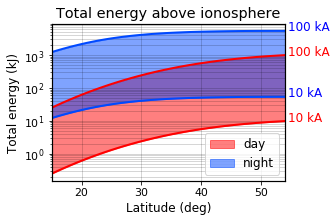

In [163]:
# Do a nice plot
import matplotlib.cm as cm

# --------------- Latex Plot Beautification --------------------------
fig_width = 3.75 
fig_height = 2.25
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

I0vec = np.array([10, 100]) # kA

pwr_day = np.outer(pwr_unscaled[1,:],pow(I0vec*1e3, 2))*1e-3
pwr_nite = np.outer(pwr_unscaled[0,:],pow(I0vec*1e3, 2))*1e-3

fig, ax = plt.subplots(1,1)

[j.set_linewidth(1.2) for j in ax.spines.itervalues()]  # Thick borders

daycolor = 'red'
nitecolor= cm.jet(50)#'blue'

ax.semilogy(avail_lats, pwr_day, linewidth=2, color=daycolor)
ax.semilogy(avail_lats, pwr_nite, linewidth=2, color=nitecolor)
ax.fill_between(avail_lats, pwr_day[:,0], pwr_day[:,1], color=daycolor, alpha=0.5, zorder=1, label='day')
ax.fill_between(avail_lats, pwr_nite[:,0], pwr_nite[:,1], color=nitecolor, alpha=0.5, zorder=1, label='night')

ax.grid('on', which='both',linestyle='-', color='k', alpha=0.2)
ax.legend()
ax.set_xlim([15,54])
ax.text(avail_lats[-1] + 0.5, pwr_day[-1,1],"100 kA", color='r')
ax.text(avail_lats[-1] + 0.5, pwr_day[-1,0],"10 kA", color='r')
ax.text(avail_lats[-1] + 0.5, pwr_nite[-1,1],"100 kA", color='b')
ax.text(avail_lats[-1] + 0.5, pwr_nite[-1,0],"10 kA", color='b')

ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('Total energy (kJ)')
ax.set_title('Total energy above ionosphere')
fig.tight_layout()
plt.subplots_adjust(right=0.85)

fig.savefig('total_energy.png', dpi=300)


## Plot input power with grid

In [60]:
from mpl_toolkits.basemap import Basemap
from spacepy import coordinates as coord
from spacepy.time import Ticktock as Ticktock

i = 2
in_lats = all_data[i]['clats']
in_lons = all_data[i]['clons']

newlats = np.linspace(in_lats[0], in_lats[-1], 200)
newlons = np.linspace(in_lons[0], in_lons[-1], 200)
interp = interpolate.RegularGridInterpolator([in_lats, in_lons], np.log10(all_data[i]['pwr']))
px, py = np.meshgrid(newlons, newlats)
pts = zip(py.ravel(), px.ravel())
flux = (interp(pts)).reshape(len(newlons), len(newlats))


# flux = all_data[i]['pwr']
lons, lats = np.meshgrid(newlons, newlats)
flashtime = datetime.datetime(2010,1,4,0,0,0)
tmp_coords = coord.Coords(zip(np.ones_like(lats.ravel()), lats.ravel(), lons.ravel()),'MAG','sph',units=['Re','deg','deg'])
tvec_datetime = [flashtime for s in lats.ravel()]
tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
tmp_coords = tmp_coords.convert('GEO','sph')


geo_lons = tmp_coords.long.reshape(np.shape(lats))
geo_lats = tmp_coords.lati.reshape(np.shape(lats))



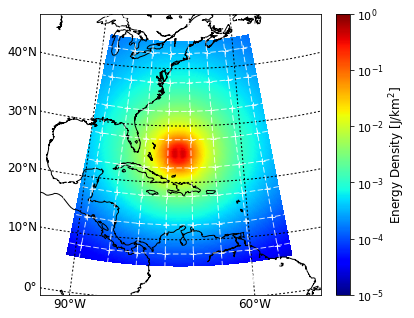

In [152]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 5 
fig_height = 3.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


# gs = gridspec.GridSpec(1,2, width_ratios=[1,0.05])

clims = [-5,0]
# fig = plt.figure()
# ax1 = plt.subplot(111)
# ax1 = plt.subplot(gs[0])
# cax = plt.subplot(gs[1])
fig, ax = plt.subplots(1,1)
# m = Basemap(ax,resolution='c',projection='ortho',lat_0 = 20, lon_0 = -70)
h = 10000
# m = Basemap(projection='nsper',satellite_height=h*1000.,\
#         lon_0=-95,lat_0=0,resolution='l',\
#     llcrnrx=0.,llcrnry=0.,urcrnrx=m.urcrnrx/2.,urcrnry=m.urcrnry/2.)
m = Basemap(projection='lcc', lon_0 = -72, lat_0 = 25, width=50*111*1e3, height = 50*111*1e3, resolution='l')

# m = Basemap(llcrnrlon=-100.,llcrnrlat=-10.,urcrnrlon=-20.,urcrnrlat=50.,
#             projection='lcc',lat_1=20.,lat_2=40.,lon_0=-60.,
#             resolution ='l',area_thresh=1000.)
x, y = m(geo_lons, geo_lats)

m.drawcoastlines()
# m.fillcontinents(color='coral',lake_color='aqua', alpha=0.7)
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,10.), labels=[True, False, False, False ])
m.drawmeridians(np.arange(0.,420.,30.), labels = [False, True, False, True])
# m.drawmapboundary(fill_color='grey')


CS1 = m.pcolormesh(x,y,flux,cmap=plt.cm.jet, vmin=clims[0], vmax=clims[1])


px, py = m(grid_lons_geo, grid_lats_geo)

for ind, b in enumerate(glats):
    m.plot(px[ind,:], py[ind,:], '--',marker='+', color='w',linewidth=1, alpha=0.8)

for ind, b in enumerate(glons):
    m.plot(px[:,ind], py[:,ind], '--', color='w',linewidth=1,alpha=0.8)

    

cb = m.colorbar(CS1, location='right', pad="5%")

cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Energy Density [J/km$^2$]')

# m.drawcoastlines(color='white')
# m.drawmapboundary()
# m.fillcontinents(color='grey',alpha=0.3)
fig.tight_layout()
fig.savefig('input_energy_with_grid.png',dpi=150)


In [135]:
# flux = all_data[i]['pwr']
grid_lons_mag = np.arange(-22.5, 23,5)
grid_lats_mag = np.arange(12.5,58,5)
print in_lats
glons, glats = np.meshgrid(grid_lons_mag, grid_lats_mag)
# flashtime = datetime.datetime(2010,1,4,0,0,0)
tmp_coords = coord.Coords(zip(np.ones_like(glats.ravel()), glats.ravel(), glons.ravel()),'MAG','sph',units=['Re','deg','deg'])
tvec_datetime = [flashtime for s in glats.ravel()]
tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
tmp_coords = tmp_coords.convert('GEO','sph')


grid_lons_geo = tmp_coords.long.reshape(np.shape(glats))
grid_lats_geo = tmp_coords.lati.reshape(np.shape(glats))

ax.scatter(grid_lons_geo, grid_lats_geo)

[ 15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5  26.5
  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5  35.5  36.5  37.5  38.5
  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5  47.5  48.5  49.5  50.5
  51.5  52.5  53.5  54.5]


/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


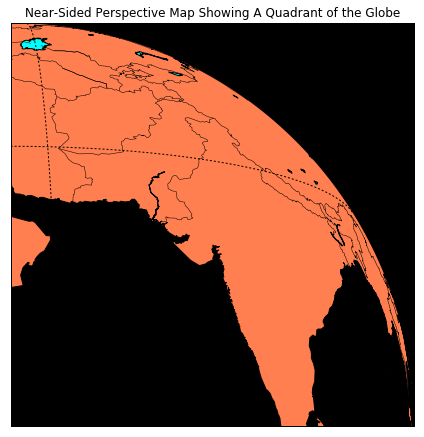